# Image Style Transfer Using CNNs


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
project_dir = "/content/drive/My Drive/Colab Notebooks/gatys/"
model_dir = project_dir
style_dir = project_dir + "style_images/"
content_dir = project_dir + "content_images/"

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## Network and Architecture

The architecture used by Gatys et al. is a subset of VGG-19. Namely, 5 "convolutional layers" (each of which is a "sandwiching" of consecutive convolutional-relu pairs) joined by a pooling layer. The authors note that better performance was achieved with average pooling, compared to max pooling. For the pooling layers, note also that the kernel size and stride are defined such that the shape of the pooled layer remains unchanged.

In [5]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=64, padding=1, kernel_size=3)
        self.conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, padding=1, kernel_size=3)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv2_1 = nn.Conv2d(in_channels=64, out_channels=128, padding=1, kernel_size=3)
        self.conv2_2 = nn.Conv2d(in_channels=128, out_channels=128, padding=1, kernel_size=3)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv3_1 = nn.Conv2d(in_channels=128, out_channels=256, padding=1, kernel_size=3)
        self.conv3_2 = nn.Conv2d(in_channels=256, out_channels=256, padding=1, kernel_size=3)
        self.conv3_3 = nn.Conv2d(in_channels=256, out_channels=256, padding=1, kernel_size=3)
        self.conv3_4 = nn.Conv2d(in_channels=256, out_channels=256, padding=1, kernel_size=3)
        self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv4_1 = nn.Conv2d(in_channels=256, out_channels=512, padding=1, kernel_size=3)
        self.conv4_2 = nn.Conv2d(in_channels=512, out_channels=512, padding=1, kernel_size=3)
        self.conv4_3 = nn.Conv2d(in_channels=512, out_channels=512, padding=1, kernel_size=3)
        self.conv4_4 = nn.Conv2d(in_channels=512, out_channels=512, padding=1, kernel_size=3)
        self.pool4 = nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.conv5_1 = nn.Conv2d(in_channels=512, out_channels=512, padding=1, kernel_size=3)
        self.conv5_2 = nn.Conv2d(in_channels=512, out_channels=512, padding=1, kernel_size=3)
        self.conv5_3 = nn.Conv2d(in_channels=512, out_channels=512, padding=1, kernel_size=3)
        self.conv5_4 = nn.Conv2d(in_channels=512, out_channels=512, padding=1, kernel_size=3)
    
    def forward(self, x, layer_names):
        """
        Passes input image through a modified version of VGG-19, and caches layers.

        Inputs:
        - x: image of shape (N,C,H,W)
        - layer_names: list of layers (e.g., "r11") whose activations are to be returned

        Returns:
        The activations of each layer in layer_names
        """
        out = {}  # cache all layers from forward pass

        out["r11"] = F.relu(self.conv1_1(x))
        out["r12"] = F.relu(self.conv1_2(out["r11"]))
        out["p1"] = self.pool1(out["r12"])  # note pooling is done to preserve shape

        out["r21"] = F.relu(self.conv2_1(out["p1"]))
        out["r22"] = F.relu(self.conv2_2(out["r21"]))
        out["p2"] = self.pool2(out["r22"])

        out["r31"] = F.relu(self.conv3_1(out["p2"]))
        out["r32"] = F.relu(self.conv3_2(out["r31"]))
        out["r33"] = F.relu(self.conv3_3(out["r32"]))
        out["r34"] = F.relu(self.conv3_4(out["r33"]))
        out["p3"] = self.pool3(out["r34"])

        out["r41"] = F.relu(self.conv4_1(out["p3"]))
        out["r42"] = F.relu(self.conv4_2(out["r41"]))
        out["r43"] = F.relu(self.conv4_3(out["r42"]))
        out["r44"] = F.relu(self.conv4_4(out["r43"]))
        out["p4"] = self.pool4(out["r44"])

        out["r51"] = F.relu(self.conv5_1(out["p4"]))
        out["r52"] = F.relu(self.conv5_2(out["r51"]))
        out["r53"] = F.relu(self.conv5_3(out["r52"]))
        out["r54"] = F.relu(self.conv5_4(out["r53"]))

        return [out[name] for name in layer_names]

## Loss Functions

Section 2 of Gatys et al. defines loss. Content loss is simply the (weighted) sum of  mean-squared error between the feature maps of the input image and the content reference image, across all layers. Style loss is computed similarly, except the mean-squared error is between the Gramian matrices of the feature maps. The Gramian matrix for one forward pass is the [batch matrix product](https://pytorch.org/docs/stable/generated/torch.bmm.html) between two matrices of size $(N,C,H \cdot W)$ and $(N,H \cdot W,C)$, resulting in an output of size $(N,C,C)$, where cell $(i,j)$ of the $l$-th $C\times C$ matrix denotes the "correlation" (see section 2.2 of the paper) between feature maps $i$ and $j$ in layer $l$.

In [6]:
class GramMatrix(nn.Module):
    def forward(self, input):
        N, C, H, W = input.shape
        flat = input.reshape(N, C, H * W)
        gram = torch.bmm(flat, flat.transpose(1,2))  # (N,C,C) shape
        gram.div_(H * W)  # normalize by image size
        return gram

class GramMSELoss(nn.Module):
    def forward(self, input, target_grams):
        # target_grams is the Gram matrices of the reference style image
        return nn.MSELoss()(GramMatrix()(input), target_grams)

## Image Pre-processing

The input image is pre-processed as follows:
1. Resize shorter dimension to `image_size`, and scale second dimension proportionally (see: [transforms.Resize](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Resize))
2. Convert to tensor for manipulation
3. Swap indices 0 and 2, since VGG-19 assumes input is BGR, not RGB
4. Normalize by subtracting ImageNet pixel means
5. Re-scale pixels to [0, 255]

In [7]:
image_size = 512  # see section 4 of paper
BGR_means = np.array([0.40760392, 0.45795686, 0.48501961])

pre = T.Compose([
    T.Resize(image_size),
    T.ToTensor(),  # NOTE: pixel values normalized to [0,1]
    T.Lambda(lambda x: x[[2,1,0]]),
    T.Normalize(mean=BGR_means, std=[1,1,1]),
    T.Lambda(lambda x : x.mul_(255.)),
])


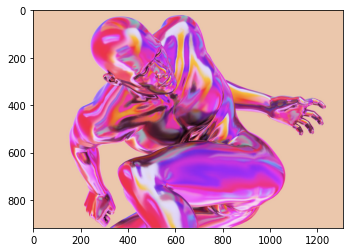

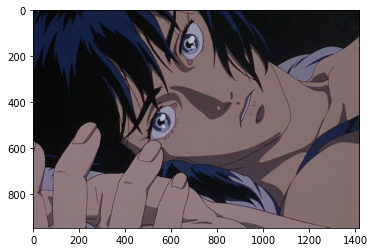

In [8]:
# load images
style_img = Image.open(style_dir + "vasjen_catro.png").convert("RGB")
content_img = Image.open(content_dir + "gits.jpg").convert("RGB")
images = (style_img, content_img)

plt.imshow(np.asarray(style_img))
plt.show()

plt.imshow(np.asarray(content_img))
plt.show()

In [9]:
# pre-process images
imgs_torch = [pre(img) for img in images]

# prepend 1 to each image shape, since each input is just a single input
# i.e., assign value of 1 to batch size
imgs_torch = [img.unsqueeze(0).to(device) for img in imgs_torch]

style_img, content_img = imgs_torch

In [16]:
def load_model(verbose=False):
    vgg = VGG()
    if verbose:
        print(vgg)
    vgg.load_state_dict(torch.load(model_dir + 'vgg_conv.pth'))
    for param in vgg.parameters():
        param.requires_grad = False
    vgg.to(device)
    return vgg

vgg = load_model(verbose=True)

VGG(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv4_1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_3): Conv2d(

## Training

In [21]:
# define layers whose features will contribute to the trainable network's loss
content_layers = ['r42']
style_layers = ['r11','r21','r31','r41', 'r51'] 
loss_layers = content_layers + style_layers
n_content, n_style = len(content_layers), len(style_layers)

# define loss functions
content_loss_fn = nn.MSELoss().to(device)
style_loss_fn = GramMSELoss().to(device)

# compute optimization targets
# Notice we detach the outputs of each forward pass, since these are static
# computations, which will not contribute to the upstream gradients of `vgg`.
# I.e., optimization targets are computed using the unchanged pre-loaded VGG-19
# parameters.
content_targets = [A.detach() for A in vgg(content_img, content_layers)]
style_targets = [GramMatrix()(A).detach() for A in vgg(style_img, style_layers)]

In [40]:
np.random.seed(69)
noise = torch.randn_like(content_img, device=device)

###################
# hyperparameters #
###################
alpha, beta = 8, 1e-2  # style-content tradeoff (section 3.1)
content_weights = [1]   # section 3
style_weights = [0.2] * len(style_layers)

# Wrap training method, so we can test multiple parameter configurations.
def run_model(n_epochs=500, verbose=True, plot_loss=False, optimizer="LBFGS",
              print_every=50, **kwargs):

    n_iter = [0]
    loss_history = []
    
    # reset model and input
    load_model()
    opt_img = noise.detach().clone().requires_grad_(True)
    #opt_img = content_img.detach().clone().requires_grad_(True)

    if optimizer == "LBFGS":
        optimizer = optim.LBFGS([opt_img])
    elif optimizer == "Adam":
        lr, weight_decay = kwargs["lr"], kwargs["weight_decay"]
        optimizer = optim.Adam(params=[opt_img], lr=lr, weight_decay=weight_decay)

    while n_iter[0] < n_epochs:

        def closure():
            optimizer.zero_grad()
            out = vgg(opt_img, loss_layers)

            content_out = out[:n_content]
            content_losses = [content_weights[i]
                              * content_loss_fn(content_out[i], content_targets[i])
                              for i in range(n_content)]
            content_loss = sum(content_losses)

            style_out = out[n_content:]
            style_losses = [style_weights[i]
                            * style_loss_fn(style_out[i], style_targets[i])
                            for i in range(n_style)]
            style_loss = sum(style_losses)

            loss = (alpha * content_loss) + (beta * style_loss)
            loss.backward()

            n_iter[0] += 1
            if verbose and n_iter[0] % print_every == 0:
                print('Iteration: %d, loss: %e'%(n_iter[0], loss.item()))
            loss_history.append(loss)
            return loss

        loss = optimizer.step(closure)

    if plot_loss:
        plt.plot(loss_history)
    
    return opt_img

Iteration: 50, loss: 2.353193e+06
Iteration: 100, loss: 1.343270e+06
Iteration: 150, loss: 1.059393e+06
Iteration: 200, loss: 9.075191e+05
Iteration: 250, loss: 8.104193e+05
Iteration: 300, loss: 7.473544e+05
Iteration: 350, loss: 7.036561e+05
Iteration: 400, loss: 6.723741e+05
Iteration: 450, loss: 6.489668e+05
Iteration: 500, loss: 6.319336e+05
CPU times: user 56.6 s, sys: 33.8 s, total: 1min 30s
Wall time: 1min 30s


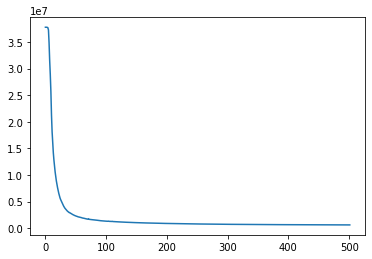

In [41]:
%%time
opt_img = run_model(plot_loss=True)

## Post-processing and Displaying Results
Post-processing undoes the transformations from pre-processing. Additionally, during training, pixel values could be outside the range of [0, 1]. So before the image in tensor-form is converted to a Pillow image, we have to clamp the negative values to 0, and the value greather than 1 to 1.

In [42]:
post = T.Compose([
    T.Lambda(lambda x : x.div_(255.)),
    T.Normalize(mean=-BGR_means, std=[1,1,1]),
    T.Lambda(lambda x: x[[2,1,0]]),
])

to_image = T.Compose([T.ToPILImage()])
def postp_and_display(save=True):
    t = post(opt_img.data[0].cpu().squeeze())
    t[t>1] = 1    
    t[t<0] = 0
    img = to_image(t)

    if save:
        img.save(project_dir + "out.png")

    plt.imshow(img)
    plt.gcf().set_size_inches(10,10)

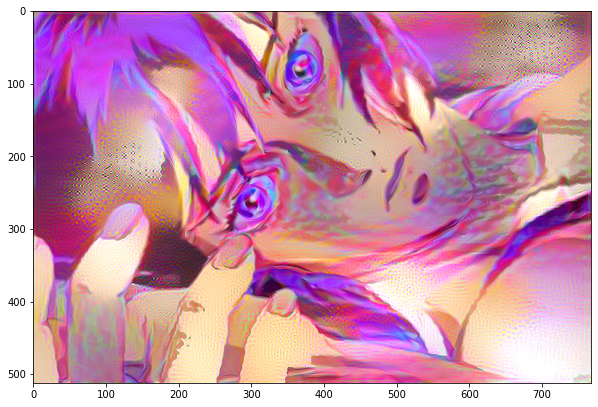

In [43]:
postp_and_display()

## Comparing Adam and LBFGS

The paper describes results using L-BFGS as the optimizer, but for fun, let's see how style transfer performance changes when Adam is used. The learning rate and weight decay was chosen after some hyperparameter tuning, both beginning with a initial range of `[1e-7, 1e-6, ..., 1e-1]`, and using the loss plot to refine the range.

Iteration: 50, loss: 1.107142e+07
Iteration: 100, loss: 5.607031e+06
Iteration: 150, loss: 3.854783e+06
Iteration: 200, loss: 2.979394e+06
Iteration: 250, loss: 2.480267e+06
Iteration: 300, loss: 2.160769e+06
Iteration: 350, loss: 1.936813e+06
Iteration: 400, loss: 1.768430e+06
Iteration: 450, loss: 1.636836e+06
Iteration: 500, loss: 1.531419e+06
CPU times: user 41 s, sys: 36.3 s, total: 1min 17s
Wall time: 1min 17s


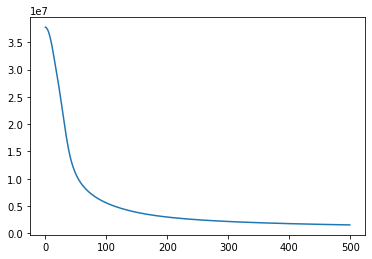

In [44]:
%%time
opt_img = run_model(optimizer="Adam", plot_loss=True, lr=8e-1, weight_decay=1e-4)

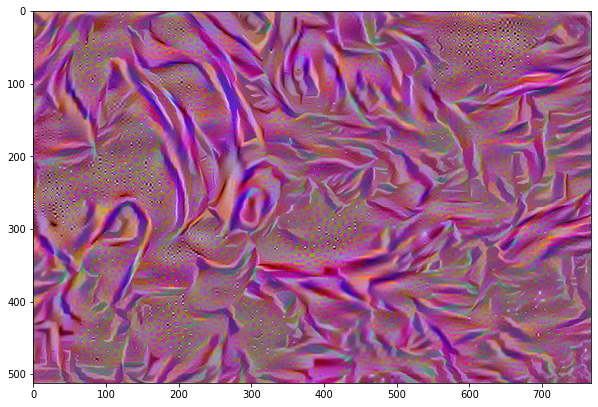

In [45]:
postp_and_display(save=False)

From the loss plot, we can see that the choice of learning rate and weight decay is good. The final loss is about an order of magnitude higher than LBFGS loss, though the training time is slightly faster than LBFGS. Most notably, for the same hyperparameters (in particular, $\alpha$ and $\beta$ in the equation $\alpha L_{content} + \beta L_{style}$, and the content/style weights for summing the loss of each target layer), the model using Adam produces a vastly different output. To achieve comparable aesthetic results, it seems these hyperparameters need to be tuned for the particular optimizer, and the aesthetic differences could be due to the large difference in loss.